# Monte Carlo SVG (unbiased)

In this notebook we aim to answer the following questions, asked in last week's [report](https://wandb.ai/angelovtt/LQG-SVG/reports/Apr-15-Project-Update--Vmlldzo2MTE3NzA).
> What's the gradient error and variance incurred by approximating SVG formulations (1,2) via Monte Carlo? (using the true model, reward, and value function) 
How does it scale with the sample regime?

---
## Setup

In [1]:
from __future__ import annotations

import textwrap
from typing import Callable

import lqsvg.torch.named as nt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import torch
import torch.nn as nn
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.envs.lqr.modules import (
    InitStateDynamics,
    LinearDynamicsModule,
    LQGModule,
    QuadraticReward,
)
from lqsvg.experiment.plot import default_figsize, plot_surface
from tqdm.auto import tqdm, trange

sns.set()
ray.init()

2021-04-30 08:54:32,110	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.15.8',
 'raylet_ip_address': '192.168.15.8',
 'redis_address': '192.168.15.8:6379',
 'object_store_address': '/tmp/ray/session_2021-04-30_08-54-31_507194_19261/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-30_08-54-31_507194_19261/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-30_08-54-31_507194_19261',
 'metrics_export_port': 62549,
 'node_id': '61b69eaf7d66291e48487ce4405d944e78cfc75cae66270c9413f119'}

### Environment

We sample a single LQG for this experiment

In [2]:
def make_generator(seed: int) -> LQGGenerator:
    return LQGGenerator(
        n_state=2,
        n_ctrl=2,
        horizon=20,
        stationary=True,
        passive_eigval_range=(0.5, 1.5),
        controllable=True,
        rng=seed,
    )

In [3]:
def make_lqg_module(generator: LQGGenerator) -> LQGModule:
    dynamics, cost, init = generator()
    return LQGModule.from_existing(dynamics, cost, init)

In [4]:
make_lqg_module(make_generator(42))

/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-kEsPsxvA-py3.8/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:934.)
  return super(Tensor, self).refine_names(names)


LQGModule(
  (trans): LinearDynamicsModule(
    (params): LinearNormalParams(
      (scale_tril): CholeskyFactor()
    )
    (dist): TVMultivariateNormal()
  )
  (reward): QuadraticReward()
  (init): InitStateDynamics(
    (scale_tril): CholeskyFactor()
    (dist): TVMultivariateNormal()
  )
)

### Policy

We use a _stabilizing_ policy generated as described in "[Generating stabilizing policies](https://wandb.ai/angelovtt/LQG-SVG/reports/Apr-9-Project-Update--Vmlldzo1OTYxNTI#generating-stabilizing-policies)".

In [5]:
from lqsvg.policy.modules import TVLinearPolicy

In [6]:
def make_stabilizing_policy(module: LQGModule, rng) -> TVLinearPolicy:
    policy = TVLinearPolicy(module.n_state, module.n_ctrl, module.horizon)
    policy.stabilize_(module.trans.standard_form(), rng=rng)
    return policy

In [7]:
def test_stabilizing_policy(seed: int):
    generator = make_generator(seed)
    return make_stabilizing_policy(make_lqg_module(generator), generator.rng)

In [8]:
test_stabilizing_policy(42)

TVLinearPolicy(
  (encoder): Identity()
  (action_linear): TVLinearFeedback()
  (squashing): Identity()
)

---
## Ground-truth policy gradient

In [9]:
from lqsvg.experiment.estimators import AnalyticSVG

In [10]:
def test_analytic(seed: int):
    generator = make_generator(seed)
    lqg_nn = make_lqg_module(generator)
    policy_nn = make_stabilizing_policy(lqg_nn, generator.rng)
    return AnalyticSVG(policy_nn, lqg_nn)()

In [11]:
test_analytic(42)

(tensor(-129.9727, grad_fn=<NegBackward>),
 (tensor([[[  1.2872,  -3.1403],
           [ -1.6807,  -6.3804]],
  
          [[  1.2976,  -5.0176],
           [ -1.6943, -10.1946]],
  
          [[  1.2976,  -6.1396],
           [ -1.6944, -12.4742]],
  
          [[  1.2976,  -6.8097],
           [ -1.6944, -13.8358]],
  
          [[  1.2976,  -7.2092],
           [ -1.6944, -14.6477]],
  
          [[  1.2976,  -7.4461],
           [ -1.6944, -15.1293]],
  
          [[  1.2976,  -7.5845],
           [ -1.6944, -15.4110]],
  
          [[  1.2976,  -7.6618],
           [ -1.6944, -15.5689]],
  
          [[  1.2976,  -7.6988],
           [ -1.6944, -15.6457]],
  
          [[  1.2976,  -7.7058],
           [ -1.6944, -15.6622]],
  
          [[  1.2976,  -7.6844],
           [ -1.6944, -15.6230]],
  
          [[  1.2976,  -7.6290],
           [ -1.6944, -15.5173]],
  
          [[  1.2976,  -7.5245],
           [ -1.6944, -15.3166]],
  
          [[  1.2976,  -7.3427],
           [ -

In [12]:
def print_val_svg(value, svg):
    msg = f"""\
    Shape: 
    - value: {value.shape}
    - dynamic gradient: {svg[0].shape}
    - static gradient: {svg[1].shape}
    Max/Min:
    - dynamic gradient: {svg[0].max()}/{svg[0].min()}
    - static gradient: {svg[1].max()}/{svg[1].min()}
    StdDev:
    - dynamic gradient: {svg[0].std()}
    - static gradient: {svg[1].std()}"""
    print(textwrap.dedent(msg))

In [13]:
print_val_svg(*test_analytic(42))

Shape: 
- value: torch.Size([])
- dynamic gradient: torch.Size([20, 2, 2])
- static gradient: torch.Size([20, 2])
Max/Min:
- dynamic gradient: 2.7360267639160156/-15.662239074707031
- static gradient: 0.0/0.0
StdDev:
- dynamic gradient: 5.757368564605713
- static gradient: 0.0


---
## Approximating (1) with samples

Recall the first SVG formulation discussed in the report:
$$
\nabla J(\theta) = \mathbb{E}_{\mathbf{s}_0 \sim \rho} \left[ \nabla_\theta V^{\mu_\theta}(\mathbf{s}_0) \right]. \qquad (1)
$$

In [14]:
from lqsvg.experiment.estimators import MonteCarloSVG

In [15]:
def test_mc_svg(seed: int):
    generator = make_generator(seed)
    lqg_nn = make_lqg_module(generator)
    policy_nn = make_stabilizing_policy(lqg_nn, generator.rng)
    mc_estimator = MonteCarloSVG(policy_nn, lqg_nn)
    mc_value, mc_svg = mc_estimator(samples=10)
    print_val_svg(mc_value, mc_svg)

In [16]:
test_mc_svg(42)

Shape: 
- value: torch.Size([])
- dynamic gradient: torch.Size([20, 2, 2])
- static gradient: torch.Size([20, 2])
Max/Min:
- dynamic gradient: 7.591177940368652/-22.461584091186523
- static gradient: 1.3279175758361816/-11.952877044677734
StdDev:
- dynamic gradient: 6.280705451965332
- static gradient: 3.427669048309326


In [17]:
import lqsvg.experiment.analysis as analysis
import lqsvg.experiment.utils as exp_util

In [18]:
def grad_estimates(
    estimator,
    sample_sizes: list[int],
    estimates_per_sample_size: int = 10,
    pbar: bool = True,
) -> list[list[lqr.Linear]]:
    progress = tqdm(
        sample_sizes, desc="Computing SVG by sample size", leave=False, disable=not pbar
    )
    svgs_by_sample_size = []
    for size in progress:
        svgs = [estimator(samples=size)[1] for _ in range(estimates_per_sample_size)]
        svgs_by_sample_size += [svgs]
    return svgs_by_sample_size

In [19]:
@ray.remote
def mc_trial(seed: int) -> pd.DataFrame:
    generator = make_generator(seed)
    with nt.suppress_named_tensor_warning():
        lqg_nn = make_lqg_module(generator)
    policy_nn = make_stabilizing_policy(lqg_nn, rng=generator.rng)
    estimator = MonteCarloSVG(policy_nn, lqg_nn)
    _, true_svg = AnalyticSVG(policy_nn, lqg_nn)()

    sample_sizes = np.linspace(1, 200, 50, dtype=int)
    data = gradient_estimation_data(
        estimator, true_svg, sample_sizes, estimates_per_sample_size=10, pbar=False
    )
    return data


def gradient_estimation_data(
    estimator,
    true_svg: lqr.Linear,
    sample_sizes: int,
    estimates_per_sample_size: int,
    pbar: bool = True,
) -> pd.DataFrame:
    svgs_by_sample_size = grad_estimates(
        estimator, sample_sizes, estimates_per_sample_size, pbar=pbar
    )

    cossims = [
        analysis.gradient_accuracy(svgs, true_svg) for svgs in svgs_by_sample_size
    ]
    empvars = [analysis.empirical_variance(svgs) for svgs in svgs_by_sample_size]

    data = {
        "#Samples": sample_sizes,
        "Avg. cos sim with true grad": cossims,
        "Avg. pairwise cos sim": empvars,
    }
    return pd.DataFrame(data)


def plot_mc_quality_vs_samples(
    num_trials: int = 10, estimates_per_sample_size: int = 10
) -> pd.DataFrame:
    data = ray.get([mc_trial.remote(s) for s in range(num_trials)])
    for i, d in enumerate(data):
        d["trial_id"] = i
    data = pd.concat(data, ignore_index=True)

    fig = plt.figure(figsize=default_figsize(2, 1))
    x = "#Samples"
    gradient_accuracy = "Avg. cos sim with true grad"
    empirical_variance = "Avg. pairwise cos sim"

    ax = fig.add_subplot(2, 1, 1)
    sns.lineplot(ax=ax, x=x, y=gradient_accuracy, data=data, ci="sd")
    ax.set_xlabel(None)

    ax = fig.add_subplot(2, 1, 2)
    sns.lineplot(ax=ax, x=x, y=empirical_variance, data=data, ci="sd")
    ax.set_xlabel("#Trajectories")
    plt.show()
    return data

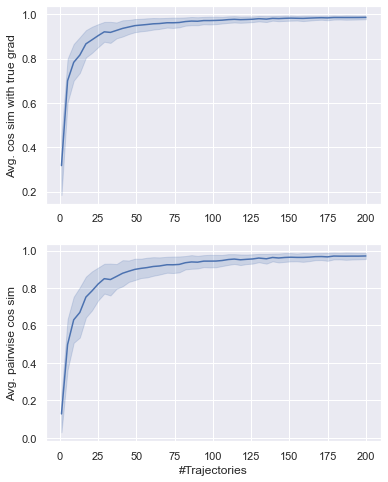

In [20]:
mc_data = plot_mc_quality_vs_samples()

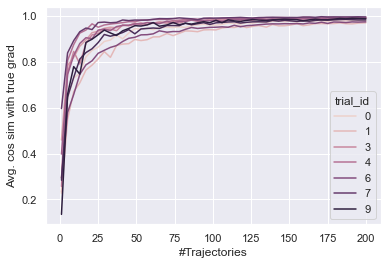

In [21]:
ax = sns.lineplot(
    x="#Samples",
    y="Avg. cos sim with true grad",
    data=mc_data,
    hue="trial_id",
    estimator=None,
)
ax.set_xlabel("#Trajectories")
plt.show()

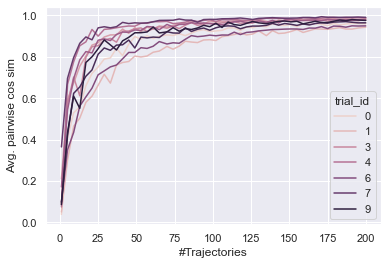

In [22]:
ax = sns.lineplot(
    x="#Samples",
    y="Avg. pairwise cos sim",
    data=mc_data,
    hue="trial_id",
    estimator=None,
)
ax.set_xlabel("#Trajectories")
plt.show()

---
## Approximating (2) with samples

Recall the second SVG formulation discussed in the report:
$$
\nabla J(\theta) = \mathbb{E}_{\mathbf{s}\sim d^{\mu_\theta}} \left[ \nabla_\theta \mu_\theta(\mathbf{s}) \nabla_{\bf a} Q^{\mu_\theta}(\mathbf{s, a}) |_{\bf a = \mu_\theta(s)}\right]. \qquad (2)
$$

In [23]:
from lqsvg.policy.modules import QuadQValue

In [24]:
from lqsvg.experiment.estimators import DPG

In [25]:
# Implement class containing boostrapped SVG estimator and obs dataset
class NStepSVG(nn.Module):
    def __init__(self, policy: TVLinearPolicy, model: LQGModule):
        super().__init__()
        self.policy = policy
        self.model = model
        self.qvalue = self.make_qvalue(policy, model)
        self.estimator = DPG(policy, model.trans, model.reward, self.qvalue)
        self.state_dataset = None
        self.n_steps: int = 0

    def setup(self, total_states: int = 1000):
        self.state_dataset = self.starting_states(self.policy, self.model, total_states)

    def sample_starting_obs(self, samples: int) -> Tensor:
        idxs = torch.randint(low=0, high=self.state_dataset.size("B"), size=(samples,))
        return nt.index_select(self.state_dataset, dim="B", index=idxs)

    def surrogate(self, samples: int = 1) -> Tensor:
        obs = self.sample_starting_obs(samples)
        return self.estimator.surrogate(obs, n_steps=self.n_steps)

    def forward(self, samples: int = 1) -> tuple[Tensor, lqr.Linear]:
        obs = self.sample_starting_obs(samples)
        return self.estimator(obs, n_steps=self.n_steps)

    @staticmethod
    def make_qvalue(policy: TVLinearPolicy, model: LQGModule) -> QuadQValue:
        return QuadQValue.from_policy(
            policy.standard_form(),
            model.trans.standard_form(),
            model.reward.standard_form(),
        )

    @staticmethod
    @torch.no_grad()
    def starting_states(policy: TVLinearPolicy, model: LQGModule, num: int) -> Tensor:
        rollout_module = MonteCarloSVG(policy, model)
        n_trajs = num // model.horizon
        obs, _, _, _, _ = rollout_module.rsample_trajectory(torch.Size([n_trajs]))
        obs = obs.flatten(["H", "B1"], "B")
        return obs

In [26]:
@ray.remote
def bt_trial(seed: int) -> pd.DataFrame:
    generator = make_generator(seed)
    lqg_nn = make_lqg_module(generator)
    policy_nn = make_stabilizing_policy(lqg_nn, rng=generator.rng)
    _, true_svg = AnalyticSVG(policy_nn, lqg_nn)()

    total_states = 1000
    estimator = NStepSVG(policy_nn, lqg_nn)
    estimator.setup(total_states)

    data = []
    for n_step in range(6):
        estimator.n_steps = n_step
        sample_sizes = np.linspace(1, total_states, 50, dtype=int)
        sub_data = gradient_estimation_data(
            estimator, true_svg, sample_sizes, estimates_per_sample_size=10, pbar=False
        )
        sub_data["NStep"] = n_step
        data += [sub_data]
    return pd.concat(data, ignore_index=True)


def bt_quality_vs_samples(num_trials: int = 10) -> pd.DataFrame:
    data = ray.get([bt_trial.remote(s) for s in range(num_trials)])
    for i, d in enumerate(data):
        d["trial_id"] = i
    return pd.concat(data, ignore_index=True)


def plot_bt_quality_vs_samples(data: pd.DataFrame):
    fig = plt.figure(figsize=default_figsize(2, 4))
    x = "#Samples"
    gradient_accuracy = "Avg. cos sim with true grad"
    empirical_variance = "Avg. pairwise cos sim"
    hue = "NStep"

    ax = fig.add_subplot(1, 2, 1)
    sns.lineplot(
        ax=ax, x=x, y=gradient_accuracy, hue=hue, style=hue, data=data, ci="sd", palette="viridis"
    )
    ax.set_xlabel(None)

    ax = fig.add_subplot(1, 2, 2)
    sns.lineplot(
        ax=ax, x=x, y=empirical_variance, hue=hue, style=hue, data=data, ci="sd", palette="viridis"
    )
    ax.set_xlabel("#States")
    plt.show()

In [27]:
bt_data = bt_quality_vs_samples()

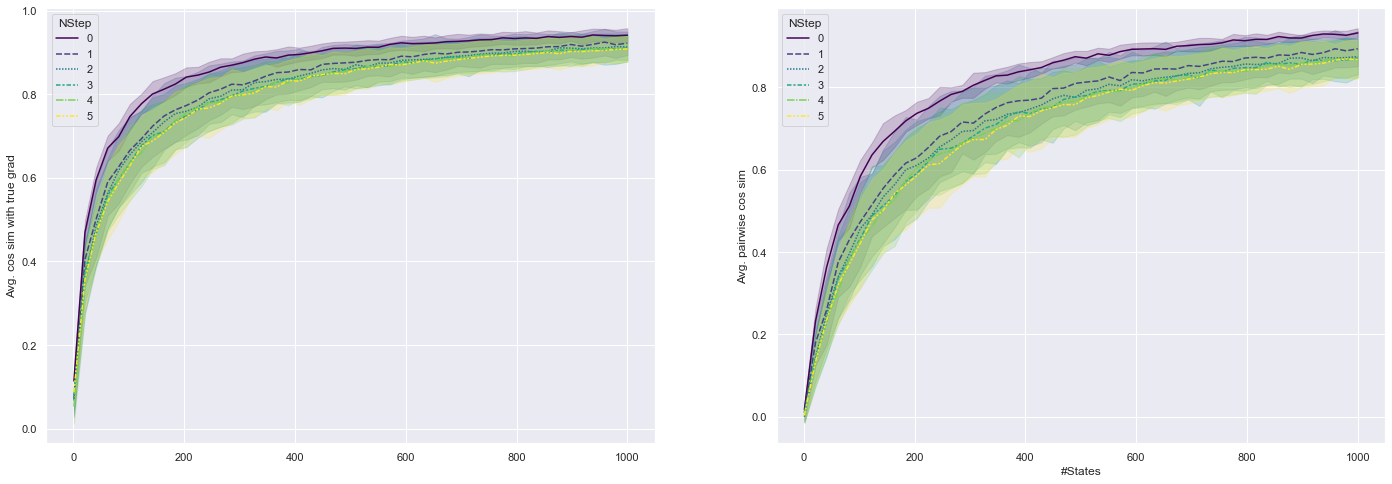

In [28]:
sns.set_theme()
plot_bt_quality_vs_samples(bt_data)

In [29]:
def show_trials_vs_quality_vs_nstep(data: pd.DataFrame):
    fig, axes = plt.subplots(6, 2, sharex=True, figsize=default_figsize(6, 2))
    axes[0, 0].get_shared_y_axes().join(*axes[:, 0])
    axes[0, 1].get_shared_y_axes().join(*axes[:, 1])
    for n_step in range(6):
        ax1, ax2 = axes[n_step]
        sns.lineplot(
            ax=ax1,
            x="#Samples",
            y="Avg. cos sim with true grad",
            data=data[data["NStep"] == n_step],
            hue="trial_id",
            estimator=None,
        )
        sns.lineplot(
            ax=ax2,
            x="#Samples",
            y="Avg. pairwise cos sim",
            data=data[data["NStep"] == n_step],
            hue="trial_id",
            estimator=None,
        )
        twin2 = ax2.twinx()
        twin2.set_ylabel(f"NStep = {n_step}", rotation=90, labelpad=10)
        twin2.get_yaxis().set_ticks([])
    plt.show()

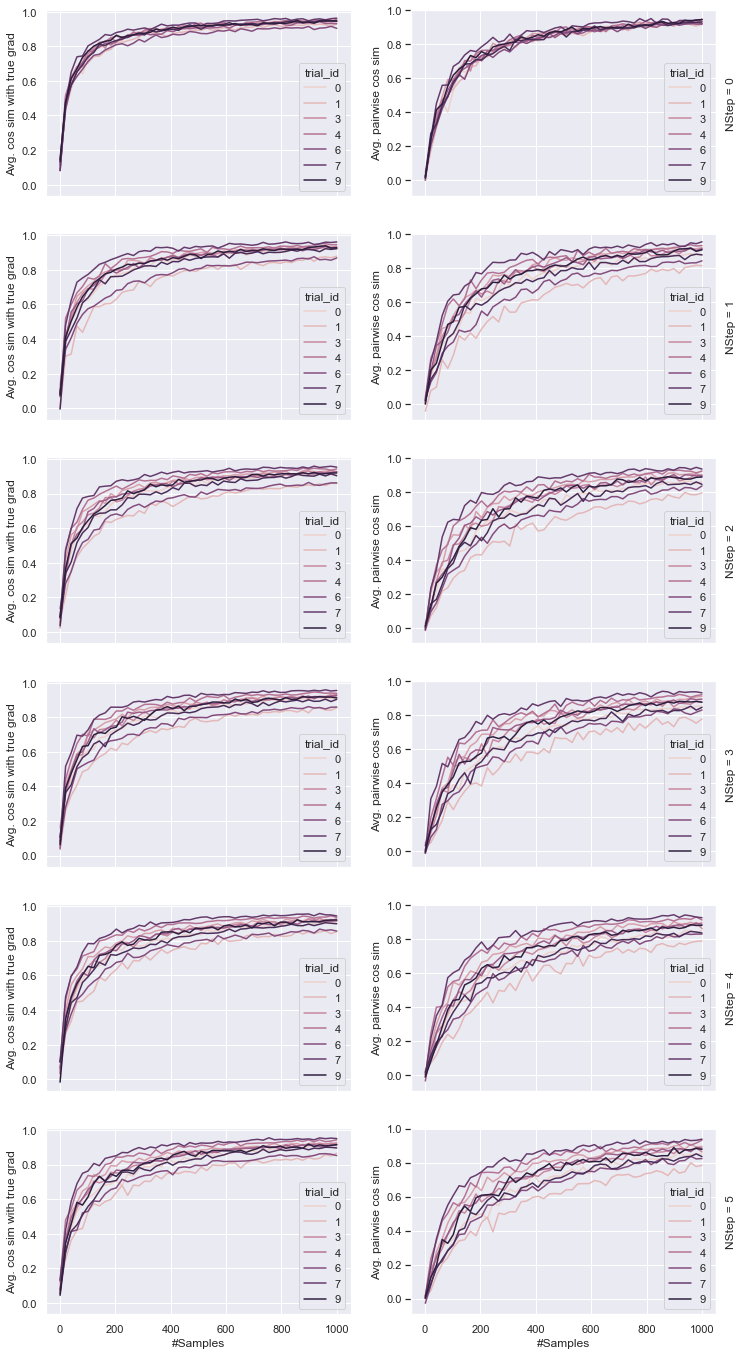

In [30]:
show_trials_vs_quality_vs_nstep(bt_data)

## Testing surface plot

In [31]:
sns.reset_orig()

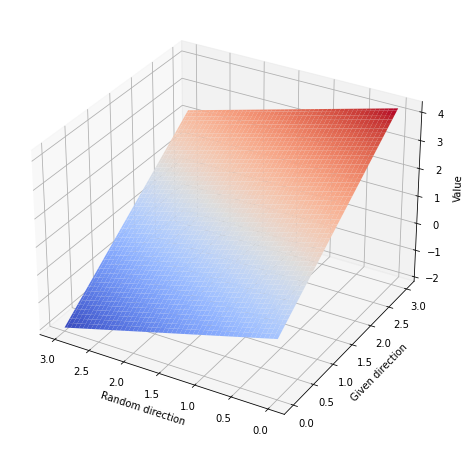

In [32]:
def f_delta(x: np.ndarray) -> np.ndarray:
    return x.dot(np.array([1, 1]))


fig = plt.figure(figsize=default_figsize(rows=2, cols=2))
X, Y, Z = analysis.optimization_surface(
    f_delta, direction=np.array([1, 1]), max_scaling=3.0, steps=100, rng=42
)
ax = plot_surface(X, Y, Z, invert_xaxis=True)
ax.set_xlabel("Random direction")
ax.set_ylabel("Given direction")
ax.set_zlabel("Value")
plt.show()

## Optimization surface for (2)

Next, we plot the expected return by taking a step along the estimated gradient via (2) and a random direction in policy parameter space

In [33]:
import lqsvg.torch.utils as tutil

In [44]:
class BootstrappedOptimSurface:
    def __init__(self, seed: int, total_states: int = 1000):
        self.rng = np.random.default_rng(seed)
        self.generator = make_generator(self.rng)
        dynamics, cost, init = self.generator()
        self.model = LQGModule.from_existing(dynamics, cost, init)
        self.policy = TVLinearPolicy(
            self.model.n_state, self.model.n_ctrl, self.model.horizon
        )
        self.policy.stabilize_(dynamics, rng=self.rng)

        self.estimator = NStepSVG(self.policy, self.model)
        self.estimator.setup(total_states)

    def plot_optim_surface(self, samples: int, n_step: int):
        self.estimator.n_steps = n_step
        _, svg = self.estimator(samples)
        direction = tutil.tensors_to_vector(svg).numpy()

        plt.figure(figsize=default_figsize(2, 2))
        X, Y, Z = analysis.optimization_surface(
            self.delta_to_return(),
            direction=direction,
            max_scaling=3.0,
            steps=20,
            rng=self.rng,
        )
        ax = plot_surface(X, Y, Z, invert_xaxis=True)
        ax.set_xlabel("Random direction")
        ax.set_ylabel("SVG direction")
        ax.set_zlabel("Policy return")
        plt.show()

    def delta_to_return(self) -> Callable[[np.ndarray], np.ndarray]:
        policy = self.policy.standard_form()
        dynamics, cost, init = self.model.standard_form()
        return analysis.delta_to_return(policy, dynamics, cost, init)

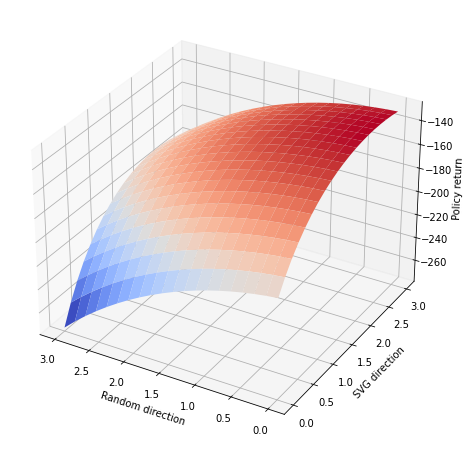

In [45]:
bt_optim_surface = BootstrappedOptimSurface(seed=4)
bt_optim_surface.plot_optim_surface(samples=200, n_step=3)

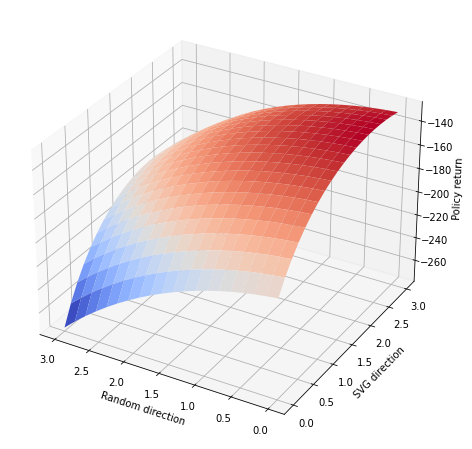

In [46]:
bt_optim_surface = BootstrappedOptimSurface(seed=4)
bt_optim_surface.plot_optim_surface(samples=200, n_step=0)

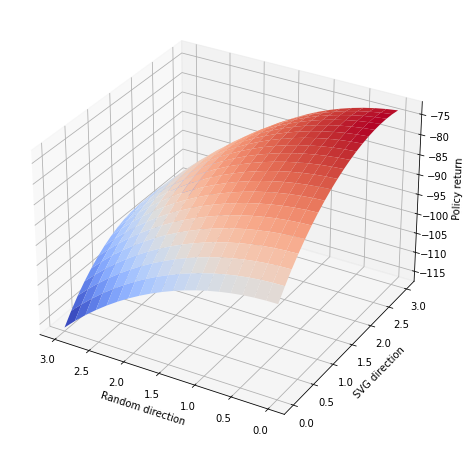

In [47]:
bt_optim_surface = BootstrappedOptimSurface(seed=42)
bt_optim_surface.plot_optim_surface(samples=200, n_step=1)

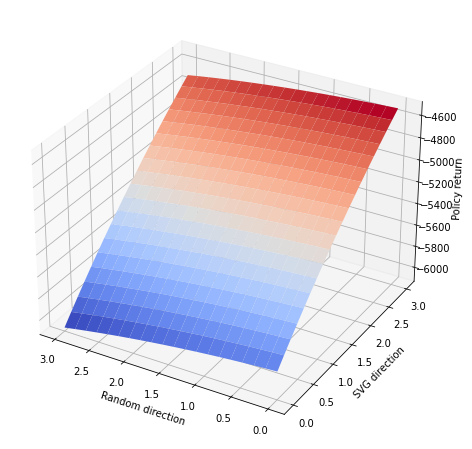

In [48]:
bt_optim_surface = BootstrappedOptimSurface(seed=123)
bt_optim_surface.plot_optim_surface(samples=200, n_step=0)

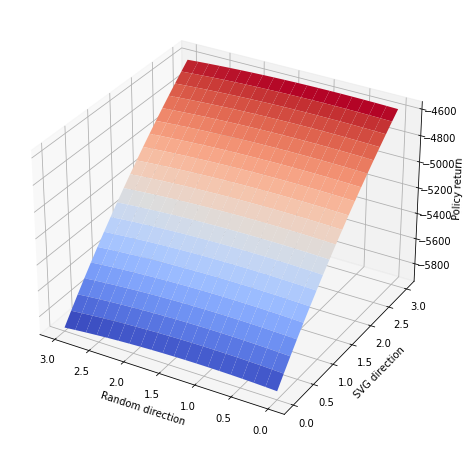

In [49]:
bt_optim_surface.plot_optim_surface(samples=200, n_step=0)